## Covid19 Analysis & Forecast
##### by Khairul Omar

### 1. Import data

In [1]:
# Import libraries
import pandas as pd
pd.options.display.max_rows = 300
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to fetch data
def fetch_data(month, date):
    url   = f'https://covid19.mathdro.id/api/daily/{month}-{date}-2020'
    r = requests.get(url)
    r.encoding = 'utf-8-sig'
    data = r.json()
    df = pd.DataFrame(data)
    if '\ufeffprovinceState' in df.columns:
        df = df.rename(columns={'\ufeffprovinceState':'provinceState'})
    df = df[['countryRegion','provinceState','confirmed','deaths','recovered']]
    for col in ['confirmed','deaths','recovered']:
        df[col] = df[col].astype(int)
    zero = 0 if date < 10 else ''
    df['date'] = pd.to_datetime(f'20200{month}{zero}{date}00', format='%Y%m%d%H', errors='ignore')
    df = df.set_index('date')
    return df

In [3]:
# Fetch Feb data
df_feb = pd.DataFrame()
for day in range(1,29+1):
    rec = fetch_data(2, day)
    df_feb = pd.concat([df_feb, rec])

# Latest Mar date
day = 13

# Fetch Mar data to date
df_mar = pd.DataFrame()
for day in range(1,day+1):
    rec = fetch_data(3, day)
    df_mar = pd.concat([df_mar, rec])

df0 = pd.concat([df_feb, df_mar])
df0 = df0.sort_values('confirmed', ascending=False)
df0 = df0.sort_index(ascending=False)
df0 = df0.rename(columns={'countryRegion':'country'})

In [4]:
# Clean up data
country_dict = {'Mainland China':'China', 'Iran (Islamic Republic of)':'Iran',
                ' Azerbaijan':'Azerbaijan', 'occupied Palestinian territory':'Palestine',
                'Taipei and environs':'Taiwan', 'Taiwan*':'Taiwan', 'Viet Nam':'Vietnam',
                'UK':'United Kingdom', 'US':'United States', 'Korea, South':'South Korea',
                'Hong Kong':'Hong Kong SAR', 'Macao':'Macao SAR', 'Czechia':'Czech Republic',
                'Holy See':'Vatican City', 'North Ireland':'Northern Ireland',
                'Russian Federation':'Russia', 'Republic of Ireland':'Ireland',
                'Republic of Korea':'South Korea', 'Republic of Moldova':'Moldova',
                'Others':'Cruise Ship'
                }
df1 = df0.copy()
df1.country = df1.country.apply(lambda row: country_dict[row] if row in list(country_dict.keys()) else row)

# National data
df1 = pd.pivot_table(df1, values=['confirmed','deaths','recovered'], index=['date','country'], columns=None, aggfunc='sum')
df1 = df1.reset_index()
dftemp = pd.DataFrame()
for country in df1.country.unique():
    dfcountry = df1[df1.country==country].copy()
    dfcountry = dfcountry.sort_index(ascending=False)
    for col in ['confirmed','deaths','recovered']:
        dfcountry[f'new_{col}'] = dfcountry[col].diff(-1)
        dfcountry[f'new_{col}'] = dfcountry[f'new_{col}'].fillna(dfcountry[col])
        dfcountry[f'new_{col}'] = dfcountry[f'new_{col}'].astype('int')
    dftemp =  pd.concat([dftemp, dfcountry])
df1 = dftemp.sort_values(['date','confirmed'], ascending=False)
df1 = df1.set_index('date')

### 2. Analyse latest data


Top 20 countries as of 13/3/2020


,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-03-13,China,80945,3180,64196,13,8,1295
2020-03-13,Italy,17660,1266,1439,5198,439,394
2020-03-13,Iran,11364,514,2959,1289,85,0
2020-03-13,South Korea,7979,66,510,110,0,177
2020-03-13,Spain,5232,133,193,2955,78,10
2020-03-13,Germany,3675,7,46,1597,4,21
2020-03-13,France,3667,79,12,1383,31,0
2020-03-13,United States,2179,47,12,516,7,0
2020-03-13,Switzerland,1139,11,4,487,7,0



New confirmed cases from 1/2/2020 to 13/3/2020


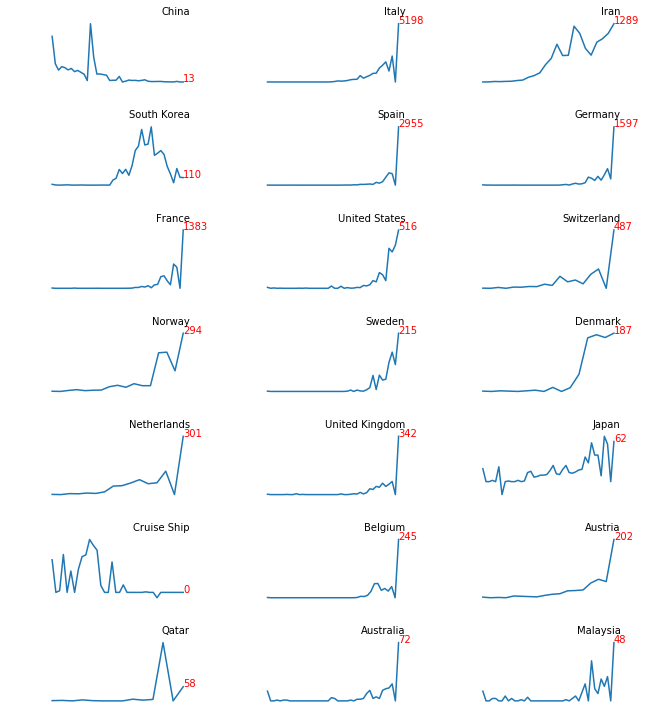

In [5]:
# Display one day data
day   = day
month = 3
zero = 0 if day < 10 else ''
date = pd.to_datetime(f'20200{month}{zero}{day}00', format='%Y%m%d%H')
oneday = pd.Timedelta(1, unit='days')
latest = df1.loc[date]
print(f'\nTop 20 countries as of {date.day}/{date.month}/2020')
display(latest[:20])

# Select diplay data
until = date
data = df1[until:]

# Plot data
print(f'\nNew confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
countries = list(latest[:20].country) + ['Malaysia']
fig, axes = plt.subplots(ncols=3, nrows=round(len(countries)/3), figsize=(9,10), constrained_layout=True)
for i, ax in zip(range(len(countries)), axes.flat):
    cdata = data[data.country==countries[i]]
    ax.plot(cdata.new_confirmed)
    cdata2 = cdata.loc[until].new_confirmed
    ax.text(until, cdata2, cdata2, color='red')
    ax.set_title(countries[i], fontsize=10, loc='right')
    ax.axis('off')
plt.show()

### 3. ARIMA time series forecasting

Validate stationarity from time shifts
Shift i=1: adfuller:0.5, mean:1.9
Shift i=2: adfuller:0.559, mean:0.5


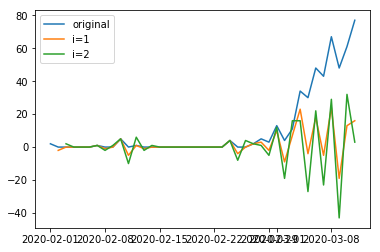

In [6]:
dfuk0 = df1[df1.country=='United Kingdom'].new_confirmed.sort_index()

# Select relevant period
dfuk  = dfuk0[:-2]

# Shift data
dfuk1  = dfuk - dfuk.shift(1)
dfuk2  = dfuk1 - dfuk1.shift(1)
print(f'Validate stationarity from time shifts')
print(f'Shift i=1: adfuller:{round(adfuller(dfuk1[1:])[1],3)}, mean:{round(np.nanmean(dfuk1),1)}')
print(f'Shift i=2: adfuller:{round(adfuller(dfuk1[2:])[1],3)}, mean:{round(np.nanmean(dfuk2),1)}')

plt.plot(dfuk, label='original')
plt.plot(dfuk1, label='i=1')
plt.plot(dfuk2, label='i=2')
plt.legend()
plt.show()

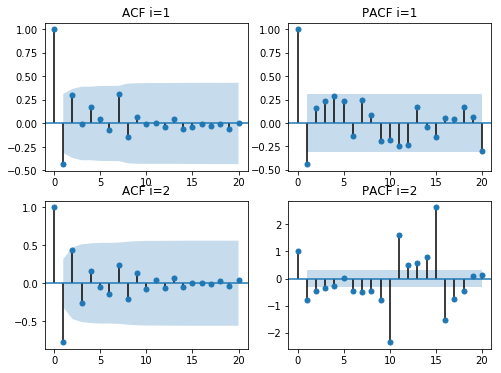

In [7]:
# Check ACF & PCF
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,6))
plot_acf(dfuk1[1:], lags=20, ax=axes.flat[0], title='ACF i=1')
plot_pacf(dfuk1[1:], lags=20, ax=axes.flat[1], title='PACF i=1')
plot_acf(dfuk2[2:], lags=20, ax=axes.flat[2], title='ACF i=2')
plot_pacf(dfuk2[2:], lags=20, ax=axes.flat[3], title='PACF i=2');

In [8]:
# Run model
p, d, q = 1, 2, 1
sarima = SARIMAX(dfuk, order=(p, d, q),
                enforce_stationarity=False).fit()
# print(sarima.summary())
# sarima.plot_diagnostics(figsize=(12,7));

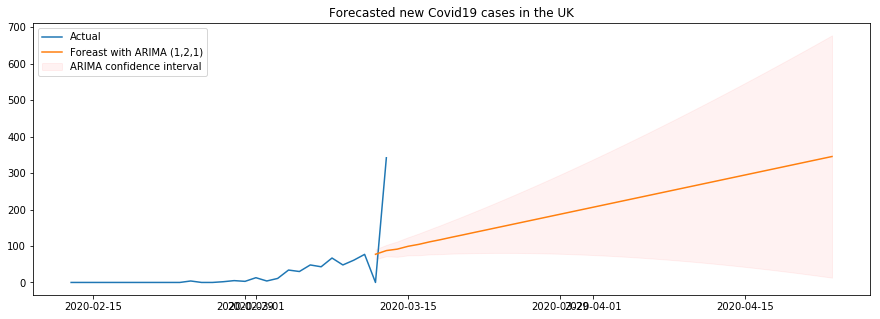

In [9]:
# Set plotting periods
test_start = dfuk.index.max() + oneday
test_end   = test_start + oneday * 7*6
act_start  = test_start - oneday * 7*4
pred = sarima.predict(start=test_start, end=test_end, dynamic=True)
pred_conf = sarima.get_forecast(len(pred)).conf_int()

# Plot data
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(dfuk0[act_start:], label='Actual')
plt.plot(pred, label='Foreast with ARIMA (1,2,1)')
plt.fill_between(pred.index, pred_conf.iloc[:,1], pred_conf.iloc[:,0].clip(0), color='r', alpha=.05, label='ARIMA confidence interval');
plt.legend(loc='upper left')
ax.set_title('Forecasted new Covid19 cases in the UK')
plt.show()